#### Instaling Libraries

In [0]:
%python
%pip install shap
%pip install xgboost

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.


#### Importing Libraries

In [0]:
%python
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib
import seaborn as sns
import shap
import xgboost as xgb
from itertools import product # To perform all possible combinations bewteen parameters
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, recall_score, roc_curve
from datetime import datetime, timedelta
reset = True

#### Loading Datasets

In [0]:
%python
data_id = 79
exec(urllib.request.urlopen('https://drive.google.com/uc?export=download&id=151MlxWk3Nk-Q3emLDyOFRxPA8lCqgGt-').read())

Initaializing ml79 database.... on first run this will take a couple of minutes.
Loaded table: customers
Removing: customers
Loaded table: products
Removing: products
Loaded table: receipt_lines
Removing: receipt_lines
Loaded table: receipts
Removing: receipts
Loaded table: stores
Removing: stores
Done.

Your individual report for this dataset can be downloaded by clicking the link / copying the URL into a browser:


<string>:116: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


https://community.cloud.databricks.com/files/ConsultingCorp_Report_ml79.pdf?o=2518561049428644

All tables from your dataset as listed below. Tables are linked with one-to-many relationships when the field names are the same. Use the SQL:
SHOW TABLES
to list all tables, including those you have generated.
┏━━━━━━━━━━━━━┓
┃ customers   ┃
┣━━━━━━━━━━━━━┫
┃ customer_id ┃
┃ first       ┃
┃ last        ┃
┃ dob         ┃
┗━━━━━━━━━━━━━┛
┏━━━━━━━━━━━━━━━━━━━━━━┓
┃ products             ┃
┣━━━━━━━━━━━━━━━━━━━━━━┫
┃ product_code         ┃
┃ product_details      ┃
┃ department_code      ┃
┃ department_name      ┃
┃ category_code        ┃
┃ category_details     ┃
┃ sub_category_code    ┃
┃ sub_category_details ┃
┗━━━━━━━━━━━━━━━━━━━━━━┛
┏━━━━━━━━━━━━━━━━━┓
┃ receipt_lines   ┃
┣━━━━━━━━━━━━━━━━━┫
┃ receipt_line_id ┃
┃ receipt_id      ┃
┃ product_code    ┃
┃ qty             ┃
┃ value           ┃
┗━━━━━━━━━━━━━━━━━┛
┏━━━━━━━━━━━━━━┓
┃ receipts     ┃
┣━━━━━━━━━━━━━━┫
┃ receipt_id   ┃
┃ purchased_at ┃
┃ customer_id  ┃
┃ store_code   ┃
┃ till_number  ┃
┗━━━━━━━━━━━━━━┛
┏━━━━━━━━━━━━┓
┃ stores     

### EDA & Data Cleaning

In [0]:
%sql
--- Negative values
SELECT qty, value, product_details
FROM receipt_lines
JOIN products
USING (product_code)
WHERE value < 0

DataFrame[qty: int, value: double, product_details: string]

In [0]:
%sql
--- Outliers
SELECT qty, product_details, value
FROM receipt_lines
JOIN products
USING (product_code)
ORDER BY 3 DESC
LIMIT 10

DataFrame[qty: int, product_details: string, value: double]

In [0]:
%sql
--- Mean values of products with outliers
SELECT AVG(avg_value) avg_outliers
FROM
  (SELECT product_details, AVG(value) avg_value
  FROM receipt_lines
  JOIN products
  USING (product_code)
  WHERE (product_details = 'RIZLA REGULAR RE' OR product_details = 'PAY POINT EACH' OR product_details = 'BENSON AND HEDGE' OR product_details = 'PAY POINT POWERC' OR product_details = 'HOME BRAND ORANGE JUI' OR product_details = 'DRUM HAND ROLLIN') AND value < 1000
  GROUP BY product_details)

DataFrame[avg_outliers: double]

In [0]:
%sql
---  Negative transaction values were converted to positive to reflect valid customer visits through prize collections or refunds. Outlier values were replaced with the average product value (excluding outliers) to correct anomalies. Both adjustments were made to preserve visit information, given their minimal presence and the importance of accurately capturing customer activity for churn prediction.
UPDATE receipt_lines
SET value = 
  CASE 
    WHEN value < 0 THEN ABS(value)
    WHEN value > 1000 THEN 7.3
    ELSE value
  END
WHERE value < 0 OR value > 500

DataFrame[num_affected_rows: bigint]

Customers who visited just once

In [0]:
%sql
SELECT COUNT(DISTINCT customer_id) FROM receipts

DataFrame[count(DISTINCT customer_id): bigint]

In [0]:
%sql
WITH visits_per_customer AS (
  SELECT
    a.customer_id,
    COUNT(*) AS total_visits
  FROM (SELECT DISTINCT customer_id, purchased_at FROM receipts) a
  GROUP BY customer_id
),

-- Grouping customers by number of visits
visit_intervals AS (
  SELECT
    CASE
      WHEN total_visits = 1 THEN '1 visit'
      ELSE 'More than 1 visit'
    END AS visit_interval,
    COUNT(*) AS customer_count
  FROM visits_per_customer
  GROUP BY
    CASE
      WHEN total_visits = 1 THEN '1 visit'
      ELSE 'More than 1 visit'
    END
)

-- Showing Table
SELECT * FROM visit_intervals;

DataFrame[visit_interval: string, customer_count: bigint]

#### Average visits per month
To calculate the average number of visits per month per customer, clients who made only one purchase throughout the entire period are excluded. This metric is then used to define intervals for analyzing the distribution of monthly buying frequency.

In [0]:
%sql
CREATE OR REPLACE TEMP VIEW monthly_buying_freq AS (
-- Step 1: Identify customers who visited only once during the entire period
WITH visits_per_customer AS (
  SELECT
    a.customer_id,
    COUNT(*) AS tot_visits
  FROM 
    (SELECT DISTINCT customer_id, purchased_at FROM receipts) a
  GROUP BY customer_id
  HAVING tot_visits = 1
),
-- Step 2: Calculate average number of monthly visits per customer (excluding one-time visitors)
avg_monthly_visits AS (
SELECT customer_id, AVG(visits) avg_monthly_visits
FROM
  (SELECT DATE_TRUNC('MONTH', r.purchased_at)::date date
    ,r.customer_id
    ,COUNT(r.customer_id) visits
  FROM (SELECT DISTINCT customer_id, purchased_at FROM receipts) r
  LEFT JOIN visits_per_customer vpc
    ON r.customer_id = vpc.customer_id
  WHERE vpc.customer_id IS NULL
  GROUP BY DATE_TRUNC('MONTH', r.purchased_at), r.customer_id)
GROUP BY customer_id
ORDER BY 2
),
-- Step 3: Categorize customers into visit frequency intervals
interval_visits AS (
  SELECT avg_monthly_visits
  ,CASE WHEN avg_monthly_visits = 1 THEN 'once a month'
    WHEN avg_monthly_visits >= 1 AND avg_monthly_visits < 2 THEN 'between 1-2'
    WHEN avg_monthly_visits >= 2 AND avg_monthly_visits < 3 THEN 'between 2-3'
    ELSE 'loyal customers' END
  avg_visit_intervals
  FROM avg_monthly_visits
),
-- Step 4: Count number of customers in each visit frequency group and assign index for ordering
clients_per_int AS (
  SELECT avg_visit_intervals
  ,COUNT(*) no_cust
  ,CASE WHEN avg_visit_intervals = 'once a month' THEN 1
  WHEN avg_visit_intervals = 'between 1-2' THEN 2
  WHEN avg_visit_intervals = 'between 2-3' THEN 3
  ELSE 4 END
  visits_int_index
  FROM interval_visits
  GROUP BY avg_visit_intervals)

SELECT * FROM clients_per_int ORDER BY visits_int_index ASC
)

DataFrame[]

In [0]:
%sql
SELECT * FROM monthly_buying_freq

DataFrame[avg_visit_intervals: string, no_cust: bigint, visits_int_index: int]

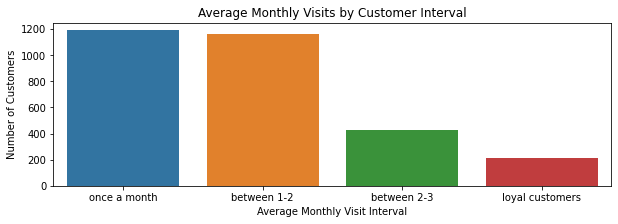

In [0]:
%python
sql = """
SELECT * FROM monthly_buying_freq
"""
df_tot_visits = spark.sql(sql).toPandas()
plt.figure(figsize=(10,3))
sns.barplot(data=df_tot_visits,x='avg_visit_intervals', y='no_cust')
plt.title('Average Monthly Visits by Customer Interval')
plt.xlabel('Average Monthly Visit Interval')
plt.ylabel('Number of Customers')
plt.show()

#### Average days between visits per category
This section will analyze the distribution of days between visits for each customer group, based on their monthly visit frequency.

In [0]:
%sql
CREATE OR REPLACE TEMP VIEW cust_monthly_buying_freq_categories AS (
-- Step 1: Identify customers who have only one recorded visit
WITH visits_per_customer AS (
  SELECT
    a.customer_id,
    COUNT(*) AS tot_visits
  FROM (SELECT DISTINCT customer_id, purchased_at FROM receipts) a
  GROUP BY customer_id
  HAVING tot_visits = 1
),
-- Step 2: Calculate the average number of monthly visits for each customer, excluding one-time visitors
avg_monthly_visits AS (
SELECT customer_id, AVG(visits) avg_monthly_visits
FROM
  (SELECT DATE_TRUNC('MONTH', r.purchased_at)::date date
    ,r.customer_id
    ,COUNT(r.customer_id) visits
  FROM (SELECT DISTINCT customer_id, purchased_at FROM receipts) r
  LEFT JOIN visits_per_customer vpc
    ON r.customer_id = vpc.customer_id
  WHERE vpc.customer_id IS NULL
  GROUP BY DATE_TRUNC('MONTH', r.purchased_at), r.customer_id)
GROUP BY customer_id
ORDER BY 2
),
-- Step 3: Assign a visit frequency category to each customer based on their average monthly visits
interval_visits AS (
  SELECT customer_id
  ,avg_monthly_visits
  ,CASE WHEN avg_monthly_visits = 1 THEN 'once a month'
    WHEN avg_monthly_visits >= 1 AND avg_monthly_visits < 2 THEN 'between 1-2'
    WHEN avg_monthly_visits >= 2 AND avg_monthly_visits < 3 THEN 'between 2-3'
    ELSE 'loyal customers' END
  avg_visit_interval
  FROM avg_monthly_visits
)
SELECT customer_id, avg_visit_interval FROM interval_visits
)

DataFrame[]

In [0]:
%sql
-- Create or replace a temporary view that calculates the average number of days between visits
-- for each customer, grouped by their monthly buying frequency category
CREATE OR REPLACE TEMP VIEW avg_days_bet_visits AS (
-- Step 1: Select distinct visits with customer frequency category joined
WITH unique_visits AS (
  SELECT DISTINCT r.customer_id
    ,r.purchased_at AS visit_date
    ,c.avg_visit_interval
  FROM receipts r
  LEFT JOIN cust_monthly_buying_freq_categories c
    ON r.customer_id = c.customer_id
  WHERE c.customer_id IS NOT NULL
),
-- Step 2: Order visits chronologically per customer and assign row numbers
purchases_ordered AS (
  SELECT customer_id
    ,visit_date
    ,avg_visit_interval
    ,ROW_NUMBER() OVER (PARTITION BY customer_id ORDER BY visit_date) AS visit_order
  FROM unique_visits
),
-- Step 3: Calculate the number of days between consecutive visits for each customer
differences AS (
  SELECT p1.customer_id
  ,p1.avg_visit_interval
  ,DATEDIFF(p2.visit_date, p1.visit_date) AS days_between
  FROM purchases_ordered p1
  JOIN purchases_ordered p2
    ON p1.customer_id = p2.customer_id
    AND p2.visit_order = p1.visit_order + 1
)

-- Step 4: Compute the average days between visits per customer and frequency category
SELECT customer_id
  ,avg_visit_interval
  ,AVG(days_between) AS avg_days_between_visits
FROM differences
GROUP BY customer_id, avg_visit_interval
ORDER BY 2 DESC
)

DataFrame[]

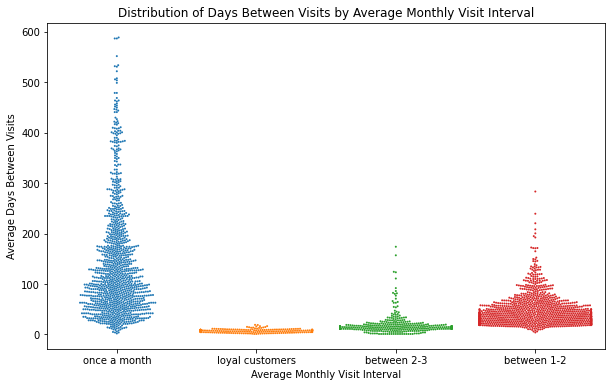

In [0]:
%python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
sql = """
SELECT * FROM avg_days_bet_visits
"""
plt.figure(figsize=(10, 6))
df_days_between_visits = spark.sql(sql).toPandas()
sns.swarmplot(data=df_days_between_visits, x='avg_visit_interval', y='avg_days_between_visits', size=2)
plt.title('Distribution of Days Between Visits by Average Monthly Visit Interval')
plt.xlabel('Average Monthly Visit Interval')
plt.ylabel('Average Days Between Visits')
plt.show()

#### Total spend over time
Analyzing total spend behavior over time provides better insight into the nature of this metric. As expected, there are noticeable peaks in December, likely due to seasonal trends. However, the overall trend shows a gradual decline in total spend, which is probably related to ongoing customer churn.

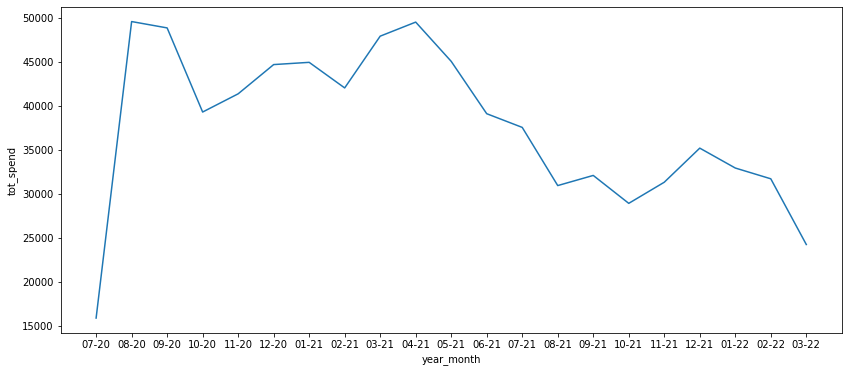

In [0]:
%python
sql = """
SELECT DATE_TRUNC('MM',purchased_at) base 
  ,DATE_FORMAT(DATE_TRUNC('MM',purchased_at),'MM-yy') year_month
  ,SUM(value) tot_spend
  ,SUM(qty) tot_items
FROM receipts
JOIN receipt_lines
USING (receipt_id)
GROUP BY base, year_month
ORDER BY base ASC
"""
trend_analysis_df = spark.sql(sql).toPandas()
plt.figure(figsize=(14,6))
sns.lineplot(data=trend_analysis_df, x=trend_analysis_df.year_month, y=trend_analysis_df.tot_spend)
plt.show()

#### Creating dataset

In [0]:
%python
def get_dataset(ref_date, cols_drop, ows=35, tws=7, no_windows=4):
# --- SQL segment to build main churn prediction dataset ---
  df = pd.DataFrame()
  sql_1 = """
  SELECT customer_id
  """
  sql_2 = """""" # Placeholder to accumulate lag features
  # Add recency and last active date features
  sql_3 = f"""
  ,MAX(CASE WHEN purchased_at BETWEEN date_sub(:ref_date,{no_windows}*:tws-1) AND date_sub(:ref_date,0) 
  THEN purchased_at ELSE NULL END) AS last_active_date
  ,:ref_date as ref_day
  ,DATEDIFF(date_add(:ref_date, 1),last_active_date) recency
  """
  # Define churn label: 1 if no purchases in the next output window, 0 otherwise
  sql_4 = """
  ,CASE WHEN SUM(CASE WHEN purchased_at BETWEEN date_add(:ref_date,1) AND date_add(:ref_date,:ows) THEN value ELSE 0 END) > 0 THEN 0 ELSE 1 END AS churn
  FROM receipts
  JOIN receipt_lines
  USING (receipt_id)
  JOIN products
  USING (product_code)
  GROUP BY customer_id
  HAVING SUM(CASE WHEN purchased_at BETWEEN date_sub(:ref_date,3*:tws-1) AND date_sub(:ref_date,1) THEN value ELSE 0 END) > 0
  ORDER BY 1, 2 ASC
  """
  # Build lagged features: spend, frequency, diversity over past N weeks
  for i in range(1, no_windows + 1):
    windows = f"""
    ,SUM(CASE WHEN purchased_at BETWEEN date_sub(:ref_date,{i}*:tws-1) AND date_sub(:ref_date,{i-1}*:tws) THEN value ELSE 0 END) AS spend_lag{i}
    ,COUNT(DISTINCT CASE WHEN purchased_at BETWEEN date_sub(:ref_date,{i}*:tws-1) AND date_sub(:ref_date,{i-1}*:tws) THEN purchased_at ELSE NULL END) AS freq_lag{i}
    ,COUNT(DISTINCT CASE WHEN purchased_at BETWEEN date_sub(:ref_date,{i}*:tws-1) AND date_sub(:ref_date,{i-1}*:tws) THEN category_details else NULL END) AS div_lag{i}
    """
    sql_2 = sql_2 + windows
  # Combine all SQL parts into a single query
  sql = sql_1 + sql_2 + sql_3 + sql_4
  df_1 = spark.sql(sql,{'ows':ows,'ref_date':ref_date,'tws':tws}).toPandas()
# --- SQL segment to compute Average Days Between Purchases (ADBP) per customer ---
# adbp = Calculating the Average Time Between Purchases
  sql_adbp = f"""
  WITH purchases_window AS (
  SELECT DISTINCT customer_id
    ,purchased_at
  FROM receipts
  WHERE purchased_at <= :ref_date
  ),

  purchases_with_lags AS (
  SELECT customer_id
    ,purchased_at
    ,LAG(purchased_at) OVER (PARTITION BY customer_id ORDER BY purchased_at) AS prev_purchased_at
  FROM purchases_window
  ),

  diffs AS (
  SELECT customer_id
    ,DATEDIFF(purchased_at, prev_purchased_at) AS days_between
  FROM purchases_with_lags
  WHERE prev_purchased_at IS NOT NULL
  )

  SELECT customer_id
    ,:ref_date ref_day
    ,AVG(days_between) AS adbp
  FROM diffs
  GROUP BY customer_id;
  """
  # Run ADBP query and merge it into the main dataset
  df_adbp = spark.sql(sql_adbp,{'ows':ows,'ref_date':ref_date,'tws':tws}).toPandas()
  df_merged = df_1.merge(df_adbp, on=['customer_id','ref_day'], how='left')
  # Concatenate into final dataset and set index
  df = pd.concat([df,df_merged], ignore_index=True)
  df.set_index('customer_id',inplace=True)
  # Replacing NaN values for 0
  df.adbp.fillna(value=0, inplace=True)
  # Printing dates for reference
  #for i in range(1, no_windows + 1):
  #    window_start = pd.to_datetime(ref_date) - pd.Timedelta(days=i * tws - 1)
  #    window_end = pd.to_datetime(ref_date) - pd.Timedelta(days=(i - 1) * tws)
  #    print(f"  lag{i}: {window_start} to {window_end}")

  return df.drop(columns=cols_drop,axis=1), df.churn

#### Function for temporal cross validation

In [0]:
%python
def oot_evaluation(initial_ref_date, n_splits, model, cols_drop):
    scores = []
    ref_date = pd.to_datetime(initial_ref_date) # Start from the initial test reference date
    # Perform n_splits out-of-time evaluations
    for i in range(n_splits):
        # Define the training and testing periods based on current ref_date
        #print(f'Hold-out {i+1}')
        train_ref_date = ref_date - pd.DateOffset(months=1)
        test_ref_date = ref_date
        #print(f'Train ref: {train_ref_date.date()}')
        X_train, y_train = get_dataset(train_ref_date, cols_drop)
        #print(f'Test ref date: {test_ref_date.date()}')
        X_test, y_test = get_dataset(test_ref_date, cols_drop)
        # Traning Model
        model.fit(X_train, y_train)
        # Predicting & Evaluating
        y_pred = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
        # Saving auc scores
        scores.append(auc)
        # Moving ref. point
        ref_date = ref_date - pd.DateOffset(months=1)
    return sum(scores)/len(scores)

#### Analyzing churn rate over time

Churn label is slightly imbalanced

In [0]:
ref_date=pd.to_datetime('01/02/2022')
df_churn = pd.DataFrame()
for i in range(13):
  X1, y1 = get_dataset(ref_date=ref_date,cols_drop=['churn','last_active_date'])
  df_ = X1.merge(y1, on='customer_id', how='left')
  df_churn = pd.concat([df_churn,df_], axis=0)
  ref_date = ref_date - pd.DateOffset(months=1)
df_churn = df_churn.sort_values(by='ref_day')

df_churn_grouped = df_churn.groupby(['ref_day','churn']).size().reset_index(name='count')
monthly_totals = df_churn_grouped.groupby('ref_day')['count'].transform('sum')
df_churn_grouped['percentage'] = 100 * df_churn_grouped['count'] / monthly_totals

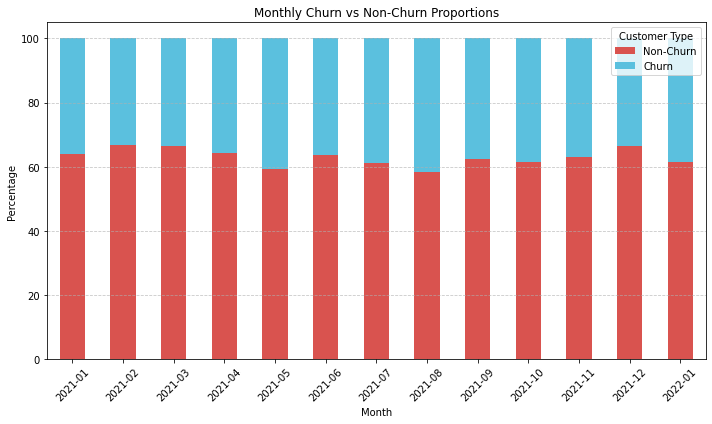

In [0]:
%python
pivot_df = df_churn_grouped.pivot(index="ref_day", columns="churn", values="count").fillna(0)
pivot_pct = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
pivot_pct.columns = ['Non-Churn', 'Churn']
pivot_pct.index = pivot_pct.index.strftime('%Y-%m')
# Stacked bar chart
ax = pivot_pct.plot(kind="bar", stacked=True, figsize=(10, 6), color=["#d9534f", "#5bc0de"])
plt.title("Monthly Churn vs Non-Churn Proportions")
plt.ylabel("Percentage")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.legend(title="Customer Type", loc="upper right")
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### FEATURE IMPORTANCE

In [0]:
%python
X,y = get_dataset(ref_date='2022-01-01', cols_drop=['churn','last_active_date','ref_day'])
feature_groups = {
  'spend_cols': ['spend_lag1','spend_lag2','spend_lag3','spend_lag4'],
  'freq_cols': ['freq_lag1','freq_lag2','freq_lag3','freq_lag4'],
  'div_cols': ['div_lag1','div_lag2','div_lag3','div_lag4'],
  'recency': ['recency'],
  'adbp': ['adbp']
  }
model = RandomForestClassifier(random_state=0).fit(X,y)

#### Permutation Importance

In [0]:
%python
def permutation_importance_grouped(model, X, y, feature_groups, n_repeats=10, random_state=0):
    # Compute baseline AUC with unshuffled features
    baseline_score = roc_auc_score(y, model.predict_proba(X)[:, 1])
    importances = {}
    # Iterate over each group of features (e.g., lagged spend, frequency, diversity)
    for group_name, group_features in feature_groups.items():
        scores = []
        # Repeat the permutation n times to reduce variance
        for _ in range(n_repeats):
            X_shuffled = X.copy()
            # Shuffle all columns in the current feature group
            for col in group_features:
                X_shuffled[col] = np.random.permutation(X_shuffled[col].values)
            # Calculate drop in AUC after shuffling this group
            score = roc_auc_score(y, model.predict_proba(X_shuffled)[:, 1])
            scores.append(baseline_score - score)
        importances[group_name] = np.mean(scores)

    return importances
# Call the function and sort the feature groups by their importance in descending order
sorted(permutation_importance_grouped(model=model, X=X, y=y, feature_groups=feature_groups).items(), key=lambda item: item[1], reverse=True)

Out[21]: [('adbp', 0.15505789909015716),
 ('spend_cols', 0.08400998918368643),
 ('div_cols', 0.052664948781574086),
 ('recency', 0.020862760068715392),
 ('freq_cols', 0.004997136858179052)]

#### SHAP Feature Importance

In [0]:
%python
# Use TreeExplainer for tree-based models like RandomForest
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)  # Returns list: [class_0, class_1] for binary classification
# Take SHAP values for the positive class (churn = 1)
shap_vals_class1 = shap_values[:, :, 1]  # Shape: (n_samples, n_features)
# Convert to DataFrame for easier manipulation
shap_df = pd.DataFrame(np.abs(shap_vals_class1), columns=X.columns)
group_importance = {}
for group_name, group_features in feature_groups.items():
    # Sum absolute SHAP values across the group and average across rows
    group_importance[group_name] = shap_df[group_features].sum(axis=1).mean()

print(sorted(group_importance.items(), key=lambda item: item[1], reverse=True))

[('adbp', 0.1253930747745161), ('spend_cols', 0.12476190792522508), ('div_cols', 0.10074182531190211), ('freq_cols', 0.05870642459516422), ('recency', 0.037672595920084505)]


### Model Evaluation

#### Random Forest Classifier

In [0]:
%python
RFC = RandomForestClassifier(random_state=0)
oot_evaluation(initial_ref_date='01/01/2022', n_splits=5, model=RFC, cols_drop=['churn','last_active_date','ref_day'])

Out[24]: 0.7958578517177485

#### XGBoost

In [0]:
%python
XGB = xgb.XGBClassifier(objective="binary:logistic")
oot_evaluation(initial_ref_date='01/01/2022', n_splits=5, model=XGB, cols_drop=['churn','last_active_date','ref_day'])

Out[25]: 0.7920678847800015

#### Logistic Regression

Standardization of individual and lagged features

In [0]:
def standardize_lagged_features(df_train, df_test, group_cols):
    df_train = df_train.copy()
    df_test = df_test.copy()
    # Standardize each group of lagged features together
    for group_name, cols in group_cols.items():
        stacked_values = df_train[cols].values.flatten()
        mean = np.mean(stacked_values)
        std = np.std(stacked_values)
        if std == 0:
            std = 1
        df_train[cols] = (df_train[cols] - mean) / std
        df_test[cols] = (df_test[cols] - mean) / std
    return df_train, df_test

def standardize_individual_features(df_train, df_test, exclude_cols):
    df_train = df_train.copy()
    df_test = df_test.copy()
    # Identify numeric columns to scale, excluding specified ones
    numeric_cols = df_train.select_dtypes(include=[np.number]).columns
    cols_to_scale = [col for col in numeric_cols if col not in exclude_cols]
    # Standardize each selected column individually using global mean and std
    for col in cols_to_scale:
        mean = df_train[col].mean()
        std = df_train[col].std()
        if std == 0:
            std = 1 # Avoid division by zero
        df_train[col] = (df_train[col] - mean) / std
        df_test[col] = (df_test[col] - mean) / std

    return df_train, df_test

In [0]:
%python
def oot_evaluation_scaled(initial_ref_date, n_splits, model, cols_drop):
    scores = []
    ref_date = pd.to_datetime(initial_ref_date)

    for i in range(n_splits):
        train_ref_date = ref_date - pd.DateOffset(months=1)
        test_ref_date = ref_date

        X_train, y_train = get_dataset(train_ref_date, cols_drop)
        X_test, y_test = get_dataset(test_ref_date, cols_drop)

        # Lagged features standardization
        X_train, X_test = standardize_lagged_features(X_train, X_test, feature_groups)

        # Indiv. features standardization
        lags = sum(feature_groups.values(), []) # Putting the lagged features in a list to avoid standardizing them again
        X_train, X_test = standardize_individual_features(X_train, X_test, exclude_cols=lags)

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
        scores.append(auc)

        ref_date = ref_date - pd.DateOffset(months=1)

    return sum(scores) / len(scores)

In [0]:
%python
LR = LogisticRegression(random_state=0)
oot_evaluation_scaled(initial_ref_date='01/01/2022', n_splits=5, model=LR, cols_drop=['churn','last_active_date','ref_day'])

Out[30]: 0.7503762338015798

### FEATURE SELECTION

In [0]:
%python
RFC = RandomForestClassifier(random_state=0)
oot_evaluation(initial_ref_date='01/01/2022', n_splits=5, model=RFC, cols_drop=['churn','last_active_date','ref_day','recency'])

Out[31]: 0.793693185512435

In [0]:
%python
RFC = RandomForestClassifier(random_state=0)
oot_evaluation(initial_ref_date='01/01/2022', n_splits=5, model=RFC, cols_drop=['churn','last_active_date','ref_day','recency','freq_lag1','freq_lag2','freq_lag3','freq_lag4'])

Out[32]: 0.7947069765137779

In [0]:
%python
cols_drop=['churn','last_active_date','ref_day','recency','freq_lag1','freq_lag2','freq_lag3','freq_lag4']

### HYPERPARAMETER TUNING

In [0]:
%python
def manual_grid_search(param_grid, initial_ref_date, n_splits, cols_drop):
    best_score = -1
    best_params = None
    results = []
    # Generate all combinations of parameters
    keys = list(param_grid.keys())
    for values in product(*param_grid.values()):
        params = dict(zip(keys, values))
        print(f"Evaluating params: {params}")
        # Create model with current set of parameters
        model = RandomForestClassifier(**params, random_state=42)
        # Evaluate using OOT
        score = oot_evaluation(initial_ref_date, n_splits, model, cols_drop)
        print(f"AUC: {score:.6f}")
        results.append((params, score))
        if score > best_score:
            best_score = score
            best_params = params

    print(f"Best params: {best_params} with AUC: {best_score:.4f}")
    return best_params, results

#### BEST MODEL EVALUATION - RANDOM FOREST CLASSIFIER

In [0]:
%python
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, None],
    'min_samples_split': [2, 5],
}
best_params, all_results = manual_grid_search(
    param_grid,
    initial_ref_date="2022-01-01",
    n_splits=5,
    cols_drop=cols_drop
)

Evaluating params: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2}
AUC: 0.825322
Evaluating params: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 5}
AUC: 0.825756
Evaluating params: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2}
AUC: 0.798210
Evaluating params: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 5}
AUC: 0.802175
Evaluating params: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 2}
AUC: 0.826200
Evaluating params: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 5}
AUC: 0.826113
Evaluating params: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2}
AUC: 0.799018
Evaluating params: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 5}
AUC: 0.805252
Best params: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 2} with AUC: 0.8262


### Defining Threshold

In [0]:
best_params = {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 2}
RFC = RandomForestClassifier(random_state=0, **best_params)
ref_date = pd.to_datetime("01/02/2022") # This ensures to use the most recent data for the final training
train_ref_date = ref_date - pd.DateOffset(months=1)
test_ref_date = ref_date
# Training and testing data
X_train, y_train = get_dataset(train_ref_date, cols_drop)
X_test, y_test = get_dataset(test_ref_date, cols_drop)
model = RFC.fit(X_train, y_train)
y_pred_labels = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]
recall = recall_score(y_test, y_pred_labels)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"roc_auc: {roc_auc:.4f}")
print(f"Recall: {recall:.4f}")

roc_auc: 0.8014
Recall: 0.4487


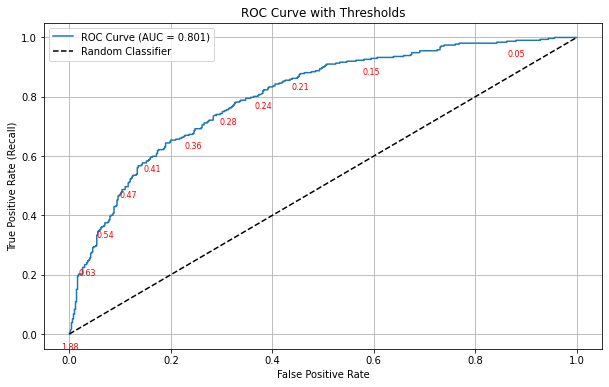

In [0]:
# Calculating ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve with Thresholds')
plt.grid(True)

# Anotar algunos thresholds en la curva
num_points = 10  # número de thresholds a mostrar
step = max(1, len(thresholds) // num_points)

for i in range(0, len(thresholds), step):
    plt.annotate(f'{thresholds[i]:.2f}',
                 (fpr[i], tpr[i]),
                 textcoords="offset points",
                 xytext=(0, -15),
                 ha='center',
                 fontsize=8,
                 color='red')

plt.legend()
plt.show()

#### Applying threshold

In [0]:
y_scores = model.predict_proba(X_test)[:,1] # Probability for class 1 (churn)
threshold = 0.3
y_pred_labels = (y_scores >= threshold).astype(int)
recall = recall_score(y_test, y_pred_labels)
print(f"Recall: {recall:.4f}")

Recall: 0.7404


### Pen Profiles

In [0]:
%python
ref_date=pd.to_datetime('01/02/2022')
for i in range(3):
  A, B = get_dataset(ref_date=ref_date, cols_drop=cols_drop)
  df_pen_portraits = pd.concat([A,B],axis=1)
  df_pen_portraits.head()
  ref_date = ref_date - pd.DateOffset(months=1)
  df_pen_portraits = df_pen_portraits[['spend_lag4','spend_lag3','spend_lag2','spend_lag1','div_lag4','div_lag3','div_lag2','div_lag1','adbp','churn']]

In [0]:
%python
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
churners = df_pen_portraits[df_pen_portraits['churn'] == 1]
non_churners = df_pen_portraits[df_pen_portraits['churn'] == 0]
print('Churners\n',churners.drop('churn',axis=1).describe().loc[['mean', 'std']])
print('Non-Churners\n',non_churners.drop('churn',axis=1).describe().loc[['mean', 'std']])

Churners
       spend_lag4  spend_lag3  spend_lag2  spend_lag1  div_lag4  div_lag3  div_lag2  div_lag1       adbp
mean    2.042680    8.146480    7.944800    7.382280  1.036000  3.160000  3.820000   3.37600  63.413694
std     6.839021   17.217977   14.266251   13.520348  3.437728  6.003212  6.590397   5.91053  86.435450
Non-Churners
       spend_lag4  spend_lag3  spend_lag2  spend_lag1  div_lag4  div_lag3  div_lag2  div_lag1       adbp
mean    8.805491    5.721168   10.074463   10.621051  3.827103  2.579439  4.507009  4.892523  25.634695
std    14.778196   10.912423   13.632891   13.495196  5.820743  4.517543  5.618008  5.929535  35.552046


#### Churners
Churners typically show declining spending behavior over time. Their average spending drops from 8.14 (lag3) and 7.94 (lag2) to 7.38 (lag1), with the lowest value being 2 in lag4, which might indicate previously low engagement that slightly increased before stopping. This pattern suggests inconsistent or unstable purchasing behavior.
In terms of diversity (div), churners maintain moderately low diversity across time, with values ranging from 1 to 3.82, suggesting that they tend to buy fewer types of products. Their most recent diversity (div_lag1) is higher than their oldest (div_lag4), indicating an increase in product variety just before disengagement.
Their average days between purchases (adbp) is very high at 63.41 days, further reinforcing their profile as infrequent and irregular shoppers.
In summary, churners are customers who spend inconsistently, purchase a limited range of products, and visit the store very infrequently.
#### Non-Churners
Non-churners demonstrate more stable and consistent spending across time, with values increasing slightly from 5.72 (lag3) to 10.62 (lag1), and overall higher than churners at almost every point. This suggests growing or steady engagement over the recent period.
Their product diversity is generally higher than that of churners, with values ranging from 2.57 to 4.89, and increasing as time progresses toward the most recent lags. This indicates that non-churners tend to explore or buy more varied products and may have a broader interest in the store’s offerings.
Their adbp is significantly lower at 25.63 days, suggesting they are much more frequent shoppers than churners.
In summary, non-churners are active, consistent shoppers who visit more often, spend regularly, and purchase a more diverse set of products.

### Instructions to Run the Model

In [0]:
RFC = RandomForestClassifier(random_state=0, n_estimators=200, max_depth=5, min_samples_split=5)
ref_date = pd.to_datetime("") # Insert the most recent data
train_ref_date = ref_date - pd.DateOffset(months=1)
test_ref_date = ref_date
# Training and testing data
X_train, y_train = get_dataset(train_ref_date, cols_drop)
X, y = get_dataset(test_ref_date, cols_drop)
model = RFC.fit(X_train, y_train)
y_scores = model.predict_proba(X)[:,1] # Probability for class 1 (churn)
threshold = 0.3 # Change threshold as needed
y_pred_labels = (y_scores >= threshold).astype(int)

In [0]:
results = X.copy()
results['predicted_churn'] = y_pred_labels
results['churn_probability'] = y_scores

churners = results[results.predicted_churn == 1].index
non_churners = results[results.predicted_churn == 0].index